# Tutorial

`Intake-esm` provides functionality to build and load intake file-based catalogs for earth system data holdings produced by projects such as CMIP, CESM, etc. 

## Building A Collection Dataset Catalog

Because `intake-esm` is an `intake` plugin, the plugin automatically appears in the set of known
plugins in the intake registry, and an associated ``intake.open_esm_metadatastore``
function is created at import time.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import intake
from pprint import pprint as print

In [2]:
intake.registry

{'yaml_file_cat': intake.catalog.local.YAMLFileCatalog,
 'yaml_files_cat': intake.catalog.local.YAMLFilesCatalog,
 'remote-xarray': intake_xarray.xarray_container.RemoteXarray,
 'netcdf': intake_xarray.netcdf.NetCDFSource,
 'opendap': intake_xarray.opendap.OpenDapSource,
 'rasterio': intake_xarray.raster.RasterIOSource,
 'xarray_image': intake_xarray.image.ImageSource,
 'zarr': intake_xarray.xzarr.ZarrSource,
 'catalog': intake.catalog.base.Catalog,
 'csv': intake.source.csv.CSVSource,
 'intake_remote': intake.catalog.base.RemoteCatalog,
 'ndzarr': intake.source.zarr.ZarrArraySource,
 'numpy': intake.source.npy.NPySource,
 'textfiles': intake.source.textfiles.TextFilesSource,
 'esm_metadatastore': intake_esm.core.ESMMetadataStoreCatalog}

To build a collection catalog, you call ``intake.open_esm_metadatastore()`` function by passing in either

1) `collection_name`:  a string corresponding to the name of one of the curated dataset collections

or 

2) `collection_input_definition`: supports one of the following three options:

   - A string corresponding to the name of one of the curated dataset collections
   - A path to a collection input YAML file,
   - A Python dictionary.

To find the list of supported/curated dataset collections:

In [3]:
from intake_esm.bld_collection_utils import _get_collection_input_files
_get_collection_input_files()

*********************************************************************
* The following collection inputs are supported out-of-the-box *
*********************************************************************

'CESM1-LE': Community Earth System Model Large Ensemble (LENS) data holdings
'GLADE-CMIP5': Coupled Model Intercomparison Project - Phase 5 data holdings on the CMIP Analysis Platform @ NCAR
'GLADE-CMIP6': Coupled Model Intercomparison Project - Phase 6 data holdings on the CMIP Analysis Platform @ NCAR
'GLADE-RDA-ERA5': ECWMF ERA5 Reanalysis data holdings
'GLADE-GMET': The Gridded Meteorological Ensemble Tool data holdings
'MPI-GE': The Max Planck Institute for Meteorology (MPI-M) Grand Ensemble (MPI-GE) data holdings


<div class="alert alert-info">

**Note:** 
    

Dataset collections are curated in [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) GitHub repository. 
    
    
</div>

Let's now build a collection catalog for CMIP6 data residing on NCAR's GLADE.

In [4]:
col = intake.open_esm_metadatastore(collection_name="GLADE-CMIP6")

Getting file listing: GLADE-DATA:AerChemMIP:posix:/glade/collections/cmip/CMIP6/AerChemMIP



Getting file listing: GLADE-DATA:CFMIP:posix:/glade/collections/cmip/CMIP6/CFMIP



Getting file listing: GLADE-DATA:CMIP:posix:/glade/collections/cmip/CMIP6/CMIP



Getting file listing: GLADE-DATA:LS3MIP:posix:/glade/collections/cmip/CMIP6/LS3MIP



Getting file listing: GLADE-DATA:LUMIP:posix:/glade/collections/cmip/CMIP6/LUMIP



Getting file listing: GLADE-DATA:PAMIP:posix:/glade/collections/cmip/CMIP6/PAMIP



Getting file listing: GLADE-DATA:ScenarioMIP:posix:/glade/collections/cmip/CMIP6/ScenarioMIP



Persisting GLADE-CMIP6 at : /glade/u/home/abanihi/.intake_esm/collections/GLADE-CMIP6.nc


When a collection catalog is created/opened, ``intake-esm`` stores its content in an ``xarray.Dataset`` object:

In [5]:
col.ds

<xarray.Dataset>
Dimensions:         (index: 418863)
Coordinates:
  * index           (index) int64 0 1 2 3 4 ... 418859 418860 418861 418862
Data variables:
    resource        (index) object ...
    resource_type   (index) object ...
    direct_access   (index) bool True True True True ... True True True True
    activity_id     (index) object ...
    experiment_id   (index) object ...
    file_basename   (index) object ...
    file_fullpath   (index) object ...
    file_dirname    (index) object ...
    grid_label      (index) object ...
    institution_id  (index) object ...
    member_id       (index) object ...
    mip_era         (index) object ...
    source_id       (index) object ...
    table_id        (index) object ...
    time_range      (index) object ...
    variable_id     (index) object ...
    version         (index) object ...
Attributes:
    created_at:             2019-08-16T00:18:32.981741
    intake_esm_version:     2019.8.5.post20
    intake_version:         0.

The same content is also available via the `.df` property, which is a ``pandas.DataFrame``:

In [6]:
col.df.head()

,resource,resource_type,direct_access,activity_id,experiment_id,file_basename,file_fullpath,file_dirname,grid_label,institution_id,member_id,mip_era,source_id,table_id,time_range,variable_id,version
index,,,,,,,,,,,,,,,,,
0,GLADE-DATA:PAMIP:posix:/glade/collections/cmip...,posix,True,PAMIP,pdSST-futAntSIC,pr_6hrPlev_CESM2_pdSST-futAntSIC_r100i1p1f1_gn...,/glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2...,glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2/...,gn,NCAR,r100i1p1f1,CMIP6,CESM2,6hrPlev,200006010000-200106010000,pr,v20190614
1,GLADE-DATA:PAMIP:posix:/glade/collections/cmip...,posix,True,PAMIP,pdSST-futAntSIC,psl_6hrPlev_CESM2_pdSST-futAntSIC_r100i1p1f1_g...,/glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2...,glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2/...,gn,NCAR,r100i1p1f1,CMIP6,CESM2,6hrPlev,200006010000-200106010000,psl,v20190614
2,GLADE-DATA:PAMIP:posix:/glade/collections/cmip...,posix,True,PAMIP,pdSST-futAntSIC,sfcWind_6hrPlev_CESM2_pdSST-futAntSIC_r100i1p1...,/glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2...,glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2/...,gn,NCAR,r100i1p1f1,CMIP6,CESM2,6hrPlev,200006010000-200106010000,sfcWind,v20190614
3,GLADE-DATA:PAMIP:posix:/glade/collections/cmip...,posix,True,PAMIP,pdSST-futAntSIC,tas_6hrPlev_CESM2_pdSST-futAntSIC_r100i1p1f1_g...,/glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2...,glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2/...,gn,NCAR,r100i1p1f1,CMIP6,CESM2,6hrPlev,200006010000-200106010000,tas,v20190614
4,GLADE-DATA:PAMIP:posix:/glade/collections/cmip...,posix,True,PAMIP,pdSST-futAntSIC,zg1000_6hrPlev_CESM2_pdSST-futAntSIC_r100i1p1f...,/glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2...,glade/collections/cmip/CMIP6/PAMIP/NCAR/CESM2/...,gn,NCAR,r100i1p1f1,CMIP6,CESM2,6hrPlev,200006010000-200106010000,zg1000,v20190614


## Getting Summary Information About The Collection Catalog

`Intake-esm` comes with utility methods that allows getting summary information about the collection catalog. 

**1) String Representation**

The most straightforward and simple way to get the summary is by printing the `col` object:

In [7]:
print(col)

GLADE-CMIP6 collection catalogue with 418863 entries:
	> 7 resource(s)

	> 1 resource_type(s)

	> 1 direct_access(s)

	> 7 activity_id(s)

	> 47 experiment_id(s)

	> 411902 file_basename(s)

	> 418863 file_fullpath(s)

	> 153386 file_dirname(s)

	> 11 grid_label(s)

	> 16 institution_id(s)

	> 132 member_id(s)

	> 1 mip_era(s)

	> 24 source_id(s)

	> 32 table_id(s)

	> 2260 time_range(s)

	> 993 variable_id(s)

	> 129 version(s)



**2) nunique() method which counts distinct observations across dataframe columns**

In [8]:
col.nunique()

resource               7
resource_type          1
direct_access          1
activity_id            7
experiment_id         47
file_basename     411902
file_fullpath     418863
file_dirname      153386
grid_label            11
institution_id        16
member_id            132
mip_era                1
source_id             24
table_id              32
time_range          2260
variable_id          993
version              129
dtype: int64

**3) unique() method which returns unique values for given columns**

In [9]:
print(col.unique(columns=['source_id', 'institution_id']))

{'institution_id': {'count': 16,
                    'values': ['NCAR',
                               'CCCma',
                               'IPSL',
                               'MIROC',
                               'MRI',
                               'NASA-GISS',
                               'CNRM-CERFACS',
                               'AWI',
                               'BCC',
                               'CAMS',
                               'CAS',
                               'E3SM-Project',
                               'EC-Earth-Consortium',
                               'NOAA-GFDL',
                               'SNU',
                               'MOHC']},
 'source_id': {'count': 24,
               'values': ['CESM2',
                          'CanESM5',
                          'IPSL-CM6A-LR',
                          'MIROC6',
                          'MRI-ESM2-0',
                          'GISS-E2-1-G',
                          'GISS-E2-1-H',
   

## Searching for Entries in the Built Collection Catalog

One of the features supported in ``intake-esm`` is querying the collection catalog.
This feature is provided via the ``search()`` method. The ``search()`` method allows the user to
specify a query by using keyword arguments. This method returns a subset of the collection catalog
with all the entries that match the provided query:

In [10]:
cat = col.search(variable_id=['hfls'], table_id=['Amon'], experiment_id=['1pctCO2', 'histSST'],
                 source_id=['CanESM5', 'IPSL-CM6A-LR'])

The results of the query are stored in a `xarray.Dataset` which is an attribute of the returned ``intake`` catalog entry object:

In [11]:
type(cat)

intake.catalog.local.LocalCatalogEntry

In [12]:
cat.ds

<xarray.Dataset>
Dimensions:         (index: 6)
Coordinates:
  * index           (index) int64 48096 72439 246361 287290 298180 316112
Data variables:
    resource        (index) object 'GLADE-DATA:CMIP:posix:/glade/collections/cmip/CMIP6/CMIP' ... 'GLADE-DATA:CMIP:posix:/glade/collections/cmip/CMIP6/CMIP'
    resource_type   (index) object 'posix' 'posix' 'posix' ... 'posix' 'posix'
    direct_access   (index) float64 1.0 1.0 1.0 1.0 1.0 1.0
    activity_id     (index) object 'CMIP' 'CMIP' 'CMIP' 'CMIP' 'CMIP' 'CMIP'
    experiment_id   (index) object '1pctCO2' '1pctCO2' ... '1pctCO2' '1pctCO2'
    file_basename   (index) object 'hfls_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc' ... 'hfls_Amon_CanESM5_1pctCO2_r3i1p2f1_gn_185001-200012.nc'
    file_fullpath   (index) object '/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p1f1/Amon/hfls/gn/v20190429/hfls/hfls_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc' ... '/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/1pct

For convenience, there's an associated `pandas.DataFrame` property:

In [13]:
cat.df.head()

,resource,resource_type,direct_access,activity_id,experiment_id,file_basename,file_fullpath,file_dirname,grid_label,institution_id,member_id,mip_era,source_id,table_id,time_range,variable_id,version
index,,,,,,,,,,,,,,,,,
48096,GLADE-DATA:CMIP:posix:/glade/collections/cmip/...,posix,1.0,CMIP,1pctCO2,hfls_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-2...,/glade/collections/cmip/CMIP6/CMIP/CCCma/CanES...,glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM...,gn,CCCma,r1i1p1f1,CMIP6,CanESM5,Amon,185001-200012,hfls,v20190429
72439,GLADE-DATA:CMIP:posix:/glade/collections/cmip/...,posix,1.0,CMIP,1pctCO2,hfls_Amon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185...,/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-C...,glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM...,gr,IPSL,r1i1p1f1,CMIP6,IPSL-CM6A-LR,Amon,185001-199912,hfls,v20180727
246361,GLADE-DATA:CMIP:posix:/glade/collections/cmip/...,posix,1.0,CMIP,1pctCO2,hfls_Amon_CanESM5_1pctCO2_r2i1p1f1_gn_185001-2...,/glade/collections/cmip/CMIP6/CMIP/CCCma/CanES...,glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM...,gn,CCCma,r2i1p1f1,CMIP6,CanESM5,Amon,185001-200012,hfls,v20190429
287290,GLADE-DATA:CMIP:posix:/glade/collections/cmip/...,posix,1.0,CMIP,1pctCO2,hfls_Amon_CanESM5_1pctCO2_r2i1p2f1_gn_185001-2...,/glade/collections/cmip/CMIP6/CMIP/CCCma/CanES...,glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM...,gn,CCCma,r2i1p2f1,CMIP6,CanESM5,Amon,185001-200012,hfls,v20190429
298180,GLADE-DATA:CMIP:posix:/glade/collections/cmip/...,posix,1.0,CMIP,1pctCO2,hfls_Amon_CanESM5_1pctCO2_r3i1p1f1_gn_185001-2...,/glade/collections/cmip/CMIP6/CMIP/CCCma/CanES...,glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM...,gn,CCCma,r3i1p1f1,CMIP6,CanESM5,Amon,185001-200012,hfls,v20190429


You can get summary information by using `.nunique()` and `.unique()` methods:

In [14]:
cat.nunique()

resource          1
resource_type     1
direct_access     1
activity_id       1
experiment_id     1
file_basename     6
file_fullpath     6
file_dirname      6
grid_label        2
institution_id    2
member_id         5
mip_era           1
source_id         2
table_id          1
time_range        2
variable_id       1
version           2
dtype: int64

In [15]:
print(cat.unique(columns=['experiment_id', 'source_id', 'grid_label', 'variable_id', 'table_id', 'institution_id']))

{'experiment_id': {'count': 1, 'values': ['1pctCO2']},
 'grid_label': {'count': 2, 'values': ['gn', 'gr']},
 'institution_id': {'count': 2, 'values': ['CCCma', 'IPSL']},
 'source_id': {'count': 2, 'values': ['CanESM5', 'IPSL-CM6A-LR']},
 'table_id': {'count': 1, 'values': ['Amon']},
 'variable_id': {'count': 1, 'values': ['hfls']}}


## Loading Results of a Query into Xarray Datasets

Once you are satisfied with the results of your query, you can use the ``to_xarray()`` method to load
the data into an xarray dataset.


<div class="alert alert-info">

**Note:** 
    

``to_xarray()`` method returns a dictionary of ``xarray`` datasets. The keys in this dictionary are constructed as follows:

- For CMIP5 data, ``key=<institute>.<model>.<experiment>.<frequency>.<modeling_realm>``
- For CMIP6 data, ``key=<institution_id>.<source_id>.<experiment_id>.<table_id>.<grid_label>``
- For CESM1-LE data, ``key=<stream>.<component>.<stream>``
- For ERA5 data, ``key=<product_type>``
- For CORDEX data: ``key=<global_climate_model>.<regional_climate_model>.<frequency>.<grid>.<bias_corrected_or_raw>.<experiment>``
    
    
</div>
    
    


In [16]:
dsets = cat.to_xarray(chunks={'time': 100})
dsets

{'CCCma.CanESM5.1pctCO2.Amon.gn': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 64, lon: 128, member_id: 5, time: 1812)
 Coordinates:
   * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
   * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
   * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
   * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' ... 'r3i1p1f1' 'r3i1p2f1'
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds  (time, bnds) object dask.array<shape=(1812, 2), chunksize=(100, 2)>
     lat_bnds   (lat, bnds) float64 dask.array<shape=(64, 2), chunksize=(64, 2)>
     lon_bnds   (lon, bnds) float64 dask.array<shape=(128, 2), chunksize=(128, 2)>
     hfls       (member_id, time, lat, lon) float32 dask.array<shape=(5, 1812, 64, 128), chunksize=(1, 100, 64, 128)>
 Attributes:
     source:                      CanESM5 (2019): \naerosol: interactive\natmo...
     parent_mip_era:              CM

In [17]:
dsets.keys()

dict_keys(['CCCma.CanESM5.1pctCO2.Amon.gn', 'IPSL.IPSL-CM6A-LR.1pctCO2.Amon.gr'])

In [18]:
ds = dsets['CCCma.CanESM5.1pctCO2.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, member_id: 5, time: 1812)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' ... 'r3i1p1f1' 'r3i1p2f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<shape=(1812, 2), chunksize=(100, 2)>
    lat_bnds   (lat, bnds) float64 dask.array<shape=(64, 2), chunksize=(64, 2)>
    lon_bnds   (lon, bnds) float64 dask.array<shape=(128, 2), chunksize=(128, 2)>
    hfls       (member_id, time, lat, lon) float32 dask.array<shape=(5, 1812, 64, 128), chunksize=(1, 100, 64, 128)>
Attributes:
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    parent_mip_era:              CMIP6
    history:                     2019-08-15 1

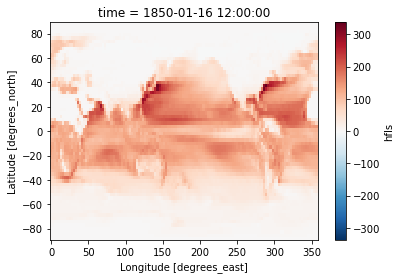

In [19]:
ds.hfls.isel(time=0).mean('member_id').plot()

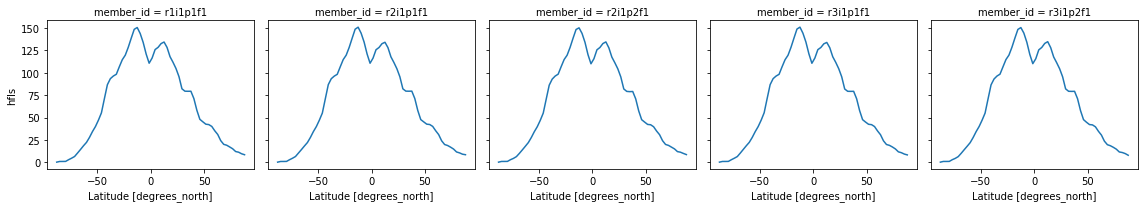

In [20]:
ds.hfls.mean(['lon', 'time']).plot(col='member_id')